# DA6401 - Assignment 2 (Part A): Building and Training CNN from Scratch

This notebook implements a CNN model for image classification on the iNaturalist dataset. We'll build the model from scratch, experiment with hyperparameters, and evaluate its performance.

## Setup and Imports

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import wandb
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Question 1: Building the CNN Model

We'll create a customizable CNN model with 5 convolution layers, each followed by activation and max-pooling.

In [2]:
class CNNModel(nn.Module):
    def __init__(self, 
                 input_channels=3,  # RGB images
                 num_classes=10,
                 filters=[32, 64, 128, 256, 512],  # Number of filters in each conv layer
                 filter_size=3,     # Size of filters (k×k)
                 activation='relu', # Activation function
                 dense_neurons=512, # Number of neurons in dense layer
                 dropout_rate=0.5,  # Dropout rate
                 use_batchnorm=True # Whether to use batch normalization
                ):
        super(CNNModel, self).__init__()
        
        # Set activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'silu':
            self.activation = nn.SiLU()
        elif activation == 'mish':
            self.activation = nn.Mish()
        else:
            self.activation = nn.ReLU()  # Default to ReLU
        
        # Create convolution blocks
        self.conv_blocks = nn.ModuleList()
        in_channels = input_channels
        
        for i, out_channels in enumerate(filters):
            block = nn.Sequential()
            
            # Convolution layer
            block.add_module(f"conv{i+1}", nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=filter_size//2))
            
            # Batch normalization (optional)
            if use_batchnorm:
                block.add_module(f"batchnorm{i+1}", nn.BatchNorm2d(out_channels))
            
            # Activation function
            block.add_module(f"activation{i+1}", self.activation)
            
            # Max pooling
            block.add_module(f"maxpool{i+1}", nn.MaxPool2d(kernel_size=2, stride=2))
            
            # Add dropout after each block except the last one
            if i < len(filters) - 1 and dropout_rate > 0:
                block.add_module(f"dropout{i+1}", nn.Dropout(dropout_rate))
            
            self.conv_blocks.append(block)
            in_channels = out_channels
        
        # Calculate output size of last conv layer
        # Assuming input image size is 224×224
        output_size = 224 // (2 ** len(filters))  # Due to max pooling with stride 2
        flattened_size = filters[-1] * output_size * output_size
        
        # Dense layers
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(flattened_size, dense_neurons)
        self.dense_activation = self.activation
        self.dense_dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(dense_neurons, num_classes)
    
    def forward(self, x):
        # Pass through convolution blocks
        for block in self.conv_blocks:
            x = block(x)
        
        # Flatten and pass through dense layers
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dense_activation(x)
        x = self.dense_dropout(x)
        x = self.output(x)
        
        return x
    
    def calculate_num_params(self):
        """Calculate the total number of parameters in the model"""
        return sum(p.numel() for p in self.parameters())

### Calculate Number of Parameters and Computations

For a typical CNN with m filters in each layer of size k×k and n neurons in the dense layer, let's calculate the number of parameters and computations.

In [3]:
def calculate_model_stats(model, input_size=(3, 224, 224)):
    """Calculate number of parameters and FLOPs for a model"""
    from torchsummary import summary
    
    # Print model summary
    print("Model Summary:")
    summary(model.to(device), input_size=input_size)
    
    # Calculate total parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nTotal parameters: {total_params:,}")
    
    # Calculate theoretical parameters and FLOPs for a generic model
    print("\nTheoretical calculation for a generic model:")
    print("For m filters in each layer of size k×k and n neurons in the dense layer:")
    print("Number of parameters = 3×m×k² + 4m²×k² + m×n + n×10")
    print("Number of computations (FLOPs) depends on input size and filter organization")

# Let's create a sample model to analyze
sample_model = CNNModel(
    input_channels=3,
    num_classes=10,
    filters=[32, 64, 128, 256, 512],
    filter_size=3,
    activation='relu',
    dense_neurons=512,
    dropout_rate=0.5,
    use_batchnorm=True
)

# Calculate stats for the sample model
calculate_model_stats(sample_model)

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
              ReLU-4         [-1, 32, 224, 224]               0
              ReLU-5         [-1, 32, 224, 224]               0
              ReLU-6         [-1, 32, 224, 224]               0
              ReLU-7         [-1, 32, 224, 224]               0
              ReLU-8         [-1, 32, 224, 224]               0
         MaxPool2d-9         [-1, 32, 112, 112]               0
          Dropout-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          18,496
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
             ReLU-14    

## Question 2: Loading and Preparing the iNaturalist Dataset

In [4]:
def get_transforms(augment=False):
    """Get transformations for training/validation/testing"""
    # Base transformations
    base_transforms = [
        transforms.Resize((224, 224)),  # Resize to standard size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ]
    
    if augment:
        # Add data augmentation for training
        train_transforms = [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
        ] + base_transforms
        return transforms.Compose(train_transforms)
    else:
        # Just base transforms for validation/testing
        return transforms.Compose(base_transforms)

def load_inaturalist_data(data_dir, val_split=0.2, augment=False):
    """Load iNaturalist dataset and split into train/val/test"""
    # Train data with/without augmentation
    train_transform = get_transforms(augment=augment)
    val_transform = get_transforms(augment=False)  # No augmentation for validation/test
    
    # Load training data
    train_dir = os.path.join(data_dir, 'train')
    train_dataset = ImageFolder(root=train_dir, transform=train_transform)
    
    # Get class distribution
    class_counts = {}
    for _, class_idx in train_dataset.samples:
        if class_idx not in class_counts:
            class_counts[class_idx] = 0
        class_counts[class_idx] += 1
    
    print(f"Class distribution in training data: {class_counts}")
    
    # Create stratified train/val split
    targets = [label for _, label in train_dataset.samples]
    train_indices, val_indices = train_test_split(
        range(len(train_dataset)),
        test_size=val_split,
        stratify=targets,
        random_state=42
    )
    
    # Create train and validation datasets
    train_dataset.transform = train_transform  # Apply augmentation to training data
    train_subset = Subset(train_dataset, train_indices)
    
    # Create validation dataset (with no augmentation)
    val_dataset = ImageFolder(root=train_dir, transform=val_transform)
    val_subset = Subset(val_dataset, val_indices)
    
    # Load test data
    test_dir = os.path.join(data_dir, 'test')
    test_dataset = ImageFolder(root=test_dir, transform=val_transform)
    
    # Verify class representation
    train_targets = [targets[i] for i in train_indices]
    val_targets = [targets[i] for i in val_indices]
    
    print("Class distribution in train subset:")
    for cls in range(len(train_dataset.classes)):
        print(f"Class {cls}: {train_targets.count(cls)}")
    
    print("\nClass distribution in validation subset:")
    for cls in range(len(val_dataset.classes)):
        print(f"Class {cls}: {val_targets.count(cls)}")
    
    return train_subset, val_subset, test_dataset, train_dataset.classes

In [5]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_inaturalist_data(data_dir, val_split=0.2, augment=True):
    # Define transformations
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]) if augment else transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Load datasets from subfolders
    train_data = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=train_transform)
    val_data = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=val_test_transform)
    test_data = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=val_test_transform)  # Optional test reuse

    class_names = train_data.classes
    return train_data, val_data, test_data, class_names

# Load dataset
data_dir = "./inaturalist_12K"
train_data, val_data, test_data, class_names = load_inaturalist_data(data_dir, val_split=0.2, augment=True)

# Dataset summary
print(f"\nNumber of classes: {len(class_names)}")
print(f"Class names: {class_names}")
print(f"\nTraining samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")



Number of classes: 10
Class names: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']

Training samples: 9999
Validation samples: 2000
Test samples: 2000


Sample Training Images:


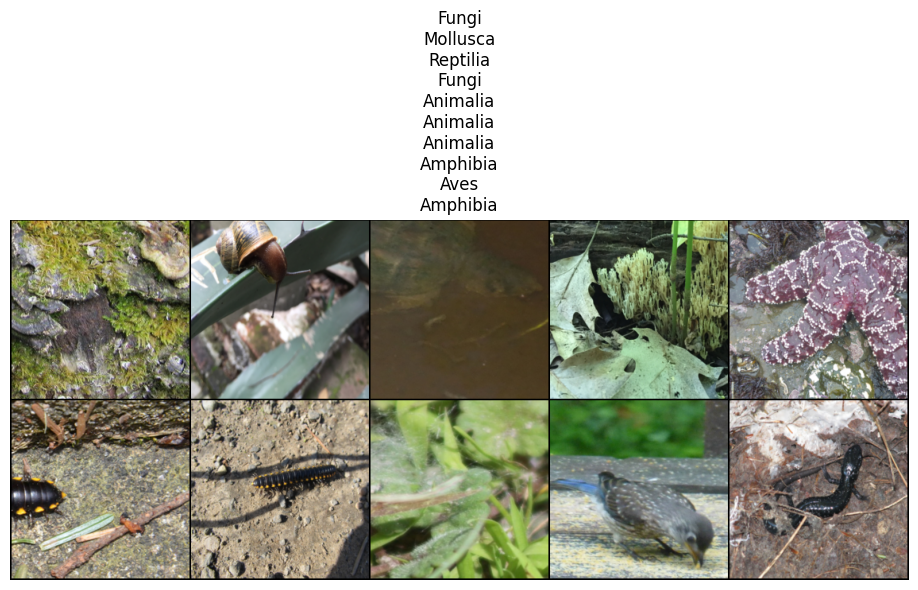

Sample Validation Images:


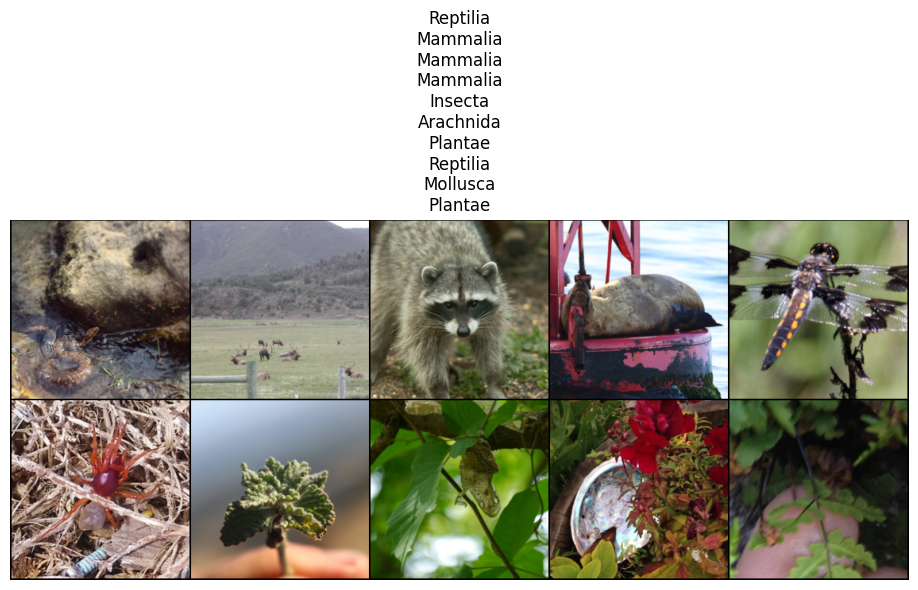

In [6]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_images(dataset, class_names, num_images=10):
    dataloader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(dataloader))

    # Unnormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)

    # Create a grid
    grid = make_grid(images, nrow=5)
    plt.figure(figsize=(15, 6))
    plt.imshow(grid.permute(1, 2, 0))
    titles = [class_names[label.item()] for label in labels]
    plt.title('\n'.join(titles), fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show samples
print("Sample Training Images:")
show_images(train_data, class_names)

print("Sample Validation Images:")
show_images(val_data, class_names)


## Create Data Loaders

In [7]:
def create_dataloaders(train_data, val_data, test_data, batch_size=64):
    """Create DataLoader objects for train, validation, and test datasets"""
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=torch.cuda.is_available()
    )

    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=torch.cuda.is_available()
    )

    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=torch.cuda.is_available()
    )

    return train_loader, val_loader, test_loader

# Create loaders
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size=64)

# Loader summary
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")


Number of batches in train loader: 157
Number of batches in validation loader: 32
Number of batches in test loader: 32


## Model Training and Evaluation Functions

In [8]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10, scheduler=None):
    """Train the model and evaluate on validation set"""
    model.to(device)
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            
        # Calculate training metrics
        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_samples = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_samples += inputs.size(0)
        
        # Calculate validation metrics
        epoch_val_loss = val_loss / val_samples
        epoch_val_acc = val_corrects.double() / val_samples
        
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())
        
        # Step the learning rate scheduler if provided
        if scheduler is not None:
            scheduler.step(epoch_val_loss)  # For ReduceLROnPlateau
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} - "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        # Log to wandb
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': epoch_loss,
            'train_acc': epoch_acc.item(),
            'val_loss': epoch_val_loss,
            'val_acc': epoch_val_acc.item(),
            'learning_rate': optimizer.param_groups[0]['lr']
        })
    
    return history

def evaluate_model(model, test_loader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    total_samples = 0
    
    all_preds = []
    all_labels = []
    all_images = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            
            # Store predictions, labels and images for visualization
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(inputs.cpu())
    
    # Calculate test metrics
    test_loss = test_loss / total_samples
    test_acc = test_corrects.double() / total_samples
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    return test_loss, test_acc.item(), all_images, all_preds, all_labels

## WandB Hyperparameter Sweeping

In [9]:
def train_with_wandb(config=None):
    # Initialize wandb
    run = wandb.init(config=config)
    config = wandb.config
    
    # Data loading with/without augmentation
    train_data, val_data, test_data, class_names = load_inaturalist_data(
        data_dir, 
        val_split=0.2, 
        augment=config.augment
    )
    
    train_loader, val_loader, test_loader = create_dataloaders(
        train_data, val_data, test_data, batch_size=config.batch_size
    )
    
    # Define filter organization based on config
    if config.filter_organization == 'same':
        filters = [config.base_filters] * 5
    elif config.filter_organization == 'double':
        filters = [config.base_filters * (2**i) for i in range(5)]
    elif config.filter_organization == 'half':
        filters = [config.base_filters * (2**(4-i)) for i in range(5)]
    else:  # Custom
        filters = [32, 64, 128, 256, 512]  # Default
    
    # Create model
    model = CNNModel(
        input_channels=3,
        num_classes=len(class_names),
        filters=filters,
        filter_size=config.filter_size,
        activation=config.activation,
        dense_neurons=config.dense_neurons,
        dropout_rate=config.dropout_rate,
        use_batchnorm=config.use_batchnorm
    )
    
    # Log model architecture
    wandb.watch(model, log='all')
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    
    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    elif config.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=config.weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=config.lr_decay_factor,
        patience=config.lr_patience
    )
    
    # Train the model
    history = train_model(
        model, 
        train_loader, 
        val_loader, 
        optimizer, 
        criterion, 
        device, 
        epochs=config.epochs, 
        scheduler=scheduler
    )
    
    # Evaluate on test set
    test_loss, test_acc, _, _, _ = evaluate_model(model, test_loader, criterion, device)
    
    # Log test results
    wandb.log({
        'test_loss': test_loss,
        'test_accuracy': test_acc
    })
    
    # Save model
    torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model.pt'))
    
    # Finish run
    wandb.finish()

# Define sweep configuration
sweep_config = {
    'method': 'bayes',  # Bayesian optimization
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'min': 0.0001,
            'max': 0.01
        },
        'batch_size': {
            'values': [32, 16, 8]
        },
        'epochs': {
            'value': 10
        },
        'optimizer': {
            'values': ['adam', 'sgd']
        },
        'base_filters': {
            'values': [16, 32, 64]
        },
        'filter_organization': {
            'values': ['same', 'double', 'half']
        },
        'filter_size': {
            'values': [3, 5]
        },
        'activation': {
            'values': ['relu', 'gelu', 'silu', 'mish']
        },
        'dense_neurons': {
            'values': [128, 256, 512]
        },
        'dropout_rate': {
            'values': [0.2, 0.3, 0.5]
        },
        'weight_decay': {
            'values': [0.0001, 0.001, 0.01]
        },
        'use_batchnorm': {
            'values': [True, False]
        },
        'augment': {
            'values': [True, False]
        },
        'lr_decay_factor': {
            'values': [0.1, 0.2]
        },
        'lr_patience': {
            'values': [2, 3]
        }

    }
}

In [10]:
# Run the hyperparameter sweep
def run_sweep():
    # Initialize wandb
    wandb.login()
    
    # Create the sweep
    sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment2_PartA8")
    
    # Run the sweep
    wandb.agent(sweep_id, function=train_with_wandb, count=1)  # Adjust count based on resources

# Uncomment to run sweep
run_sweep()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shivam20102 (shivam20102-iiit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: gmmarmz0
Sweep URL: https://wandb.ai/shivam20102-iiit/DA6401_Assignment2_PartA8/sweeps/gmmarmz0


wandb: Agent Starting Run: iwf186h0 with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	base_filters: 32
wandb: 	batch_size: 8
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	filter_organization: double
wandb: 	filter_size: 5
wandb: 	learning_rate: 0.00975442909297683
wandb: 	lr_decay_factor: 0.1
wandb: 	lr_patience: 3
wandb: 	optimizer: adam
wandb: 	use_batchnorm: True
wandb: 	weight_decay: 0.01


Epoch 1/10 - Train Loss: 3.2214, Train Acc: 0.1071 - Val Loss: 2.3001, Val Acc: 0.1185
Epoch 2/10 - Train Loss: 2.3056, Train Acc: 0.0993 - Val Loss: 2.3054, Val Acc: 0.1000
Epoch 3/10 - Train Loss: 2.3057, Train Acc: 0.0990 - Val Loss: 2.3038, Val Acc: 0.1000
Epoch 4/10 - Train Loss: 2.3059, Train Acc: 0.0973 - Val Loss: 2.3033, Val Acc: 0.1000
Epoch 5/10 - Train Loss: 2.3087, Train Acc: 0.0989 - Val Loss: 2.3059, Val Acc: 0.1000
Epoch 6/10 - Train Loss: 2.3035, Train Acc: 0.0998 - Val Loss: 2.3027, Val Acc: 0.1000
Epoch 7/10 - Train Loss: 2.3031, Train Acc: 0.0928 - Val Loss: 2.3026, Val Acc: 0.1000
Epoch 8/10 - Train Loss: 2.3030, Train Acc: 0.0959 - Val Loss: 2.3026, Val Acc: 0.1000
Epoch 9/10 - Train Loss: 2.3030, Train Acc: 0.0942 - Val Loss: 2.3027, Val Acc: 0.1000
Epoch 10/10 - Train Loss: 2.3027, Train Acc: 0.1000 - Val Loss: 2.3026, Val Acc: 0.1000
Test Loss: 2.3026, Test Accuracy: 0.1000


Training best model...
Epoch 1/20 - Train Loss: 3.2227, Train Acc: 0.1168 - Val Loss: 2.2846, Val Acc: 0.1330
Epoch 2/20 - Train Loss: 2.3339, Train Acc: 0.1164 - Val Loss: 2.3135, Val Acc: 0.1155
Epoch 3/20 - Train Loss: 2.3192, Train Acc: 0.1158 - Val Loss: 2.2832, Val Acc: 0.1320
Epoch 4/20 - Train Loss: 2.2955, Train Acc: 0.1380 - Val Loss: 2.2563, Val Acc: 0.1545
Epoch 5/20 - Train Loss: 2.2809, Train Acc: 0.1445 - Val Loss: 2.2474, Val Acc: 0.1560
Epoch 6/20 - Train Loss: 2.2817, Train Acc: 0.1543 - Val Loss: 2.2938, Val Acc: 0.1410
Epoch 7/20 - Train Loss: 2.2675, Train Acc: 0.1638 - Val Loss: 2.2016, Val Acc: 0.1870
Epoch 8/20 - Train Loss: 2.2136, Train Acc: 0.1839 - Val Loss: 2.1645, Val Acc: 0.1995
Epoch 9/20 - Train Loss: 2.1909, Train Acc: 0.2017 - Val Loss: 2.1856, Val Acc: 0.2130
Epoch 10/20 - Train Loss: 2.1709, Train Acc: 0.2050 - Val Loss: 2.1508, Val Acc: 0.2130
Epoch 11/20 - Train Loss: 2.1572, Train Acc: 0.2126 - Val Loss: 2.1331, Val Acc: 0.2245
Epoch 12/20 - Trai

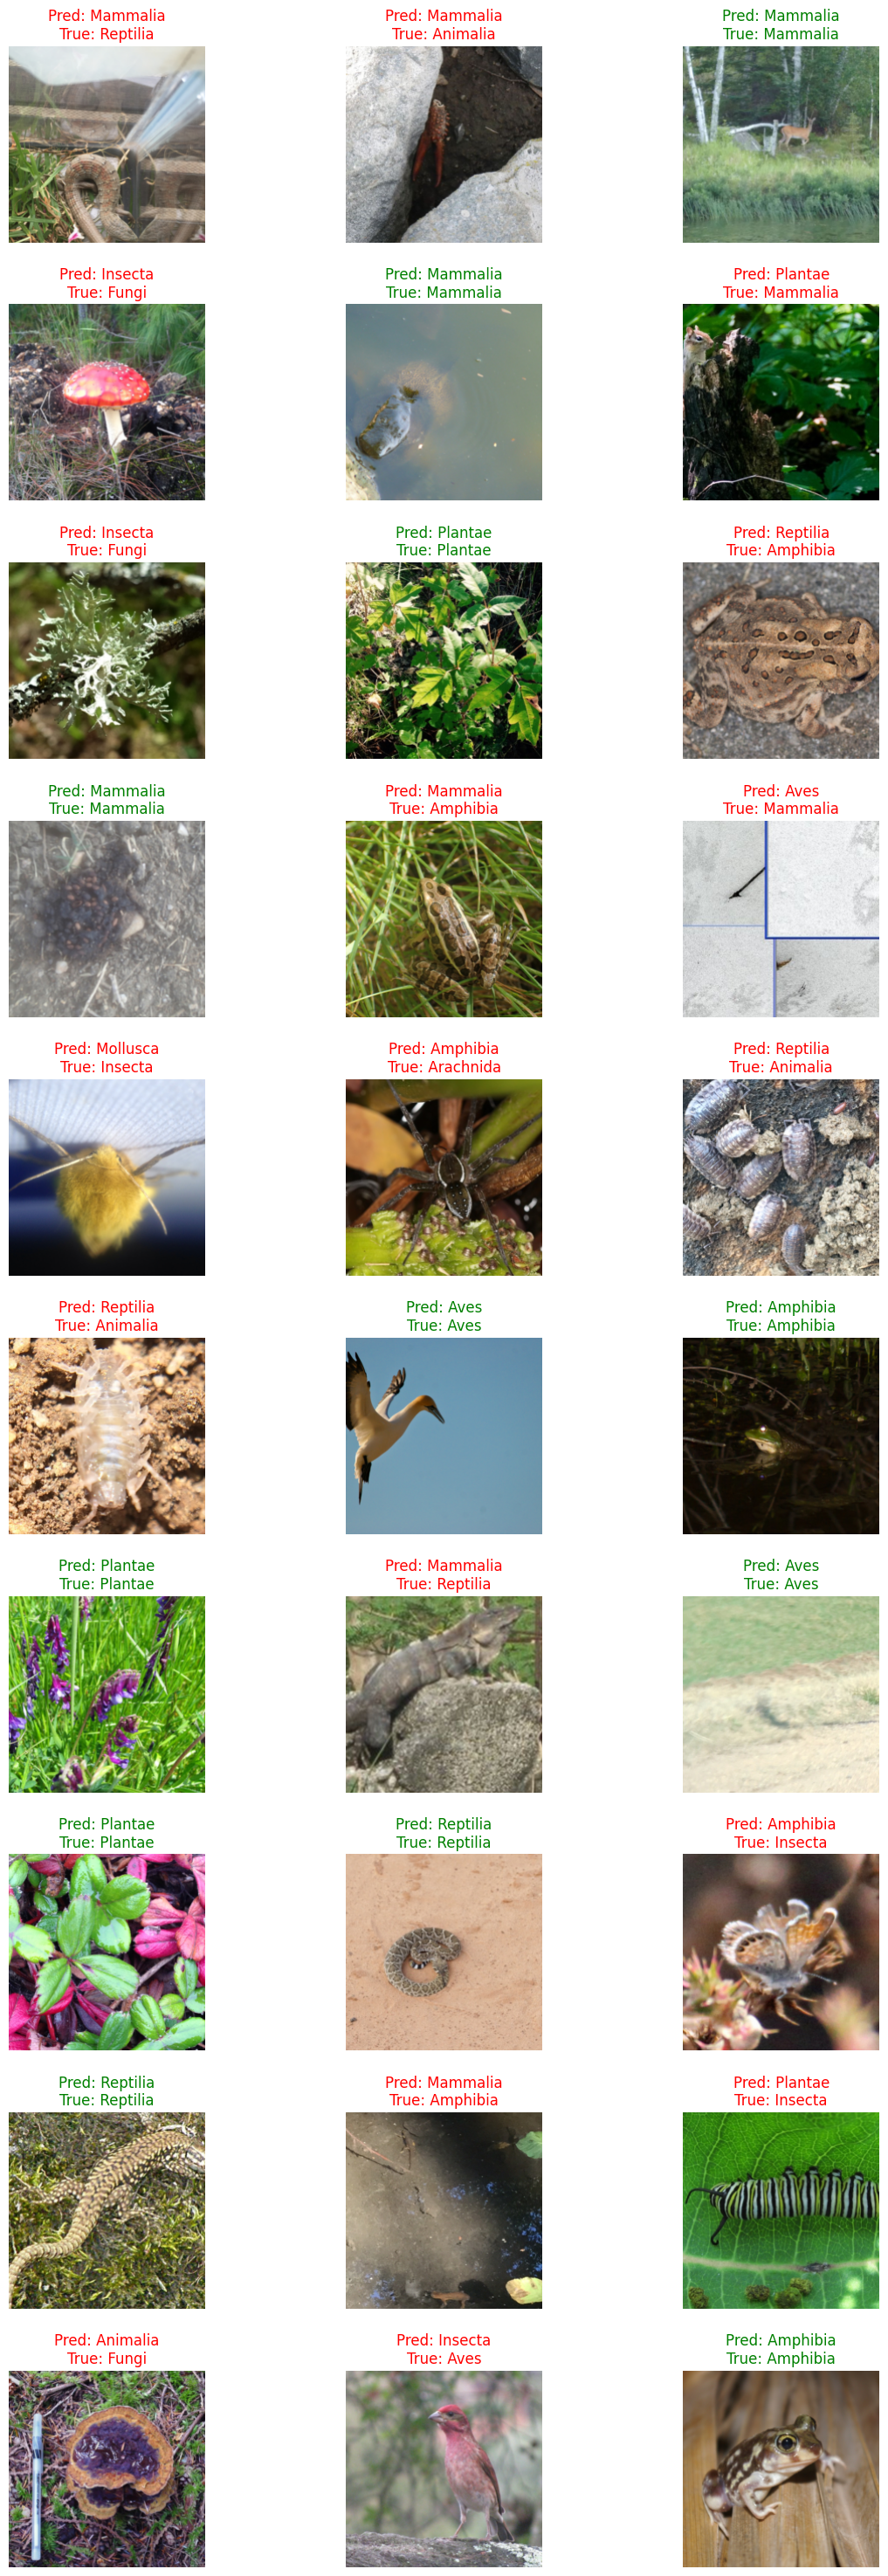